In [ ]:
import pandas as pd
import glob


files = glob.glob("../data/*.csv")

df_list = [pd.read_csv(file) for file in files]

df = pd.concat(df_list, ignore_index=True)

df.shape


(36733, 11)

In [5]:
df.info()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


np.int64(7)

In [6]:
df = df.drop_duplicates()

df.shape

(36726, 11)

In [7]:
corr_matrix = df.corr()

corr_matrix['NOX'].sort_values(ascending=False)

NOX     1.000000
CO      0.340580
AP      0.191700
AH      0.164931
TAT    -0.092711
TEY    -0.116150
CDP    -0.171247
AFDP   -0.188138
GTEP   -0.201617
TIT    -0.213869
AT     -0.558095
Name: NOX, dtype: float64

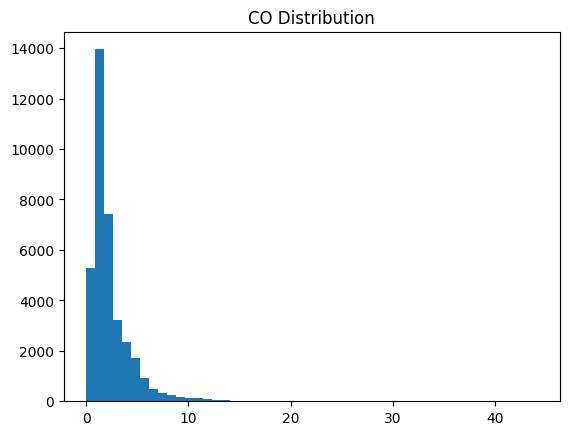

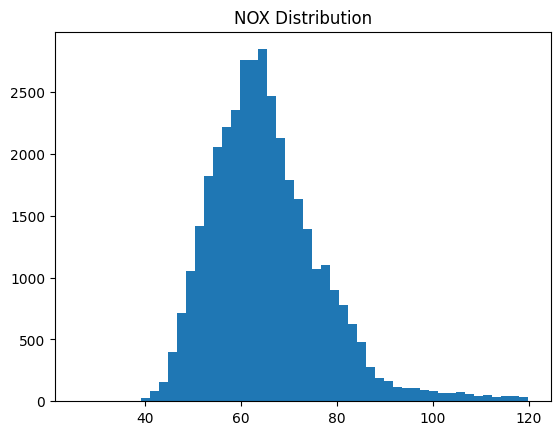

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['CO'], bins=50)
plt.title("CO Distribution")
plt.show()

plt.figure()
plt.hist(df['NOX'], bins=50)
plt.title("NOX Distribution")
plt.show()

In [7]:
df['CO'].skew(), df['NOX'].skew()


(np.float64(4.837711191820605), np.float64(1.0269582539154858))

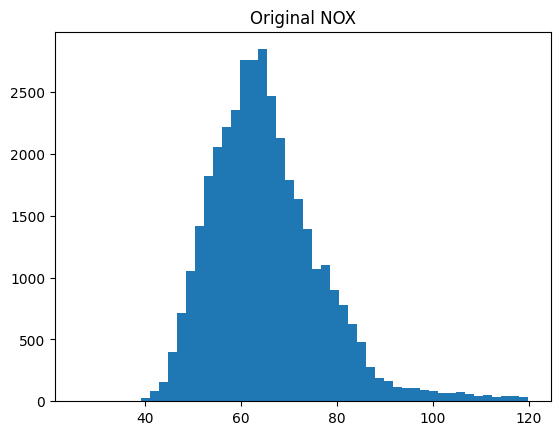

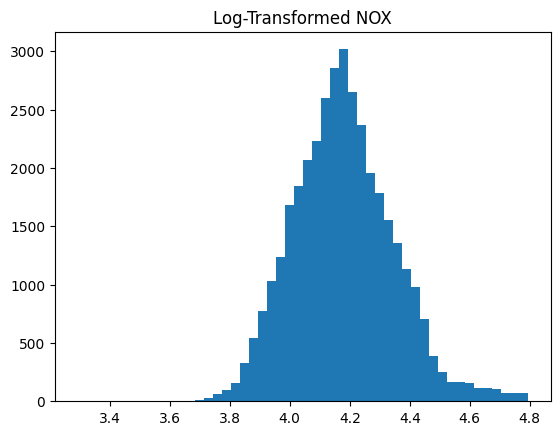

np.float64(0.3855580464350517)

In [ ]:
import numpy as np

plt.figure()
plt.hist(df['NOX'], bins=50)
plt.title("Original NOX")
plt.show()

df['NOX_log'] = np.log1p(df['NOX'])

plt.figure()
plt.hist(df['NOX_log'], bins=50)
plt.title("Log-Transformed NOX")
plt.show()

df['NOX_log'].skew()


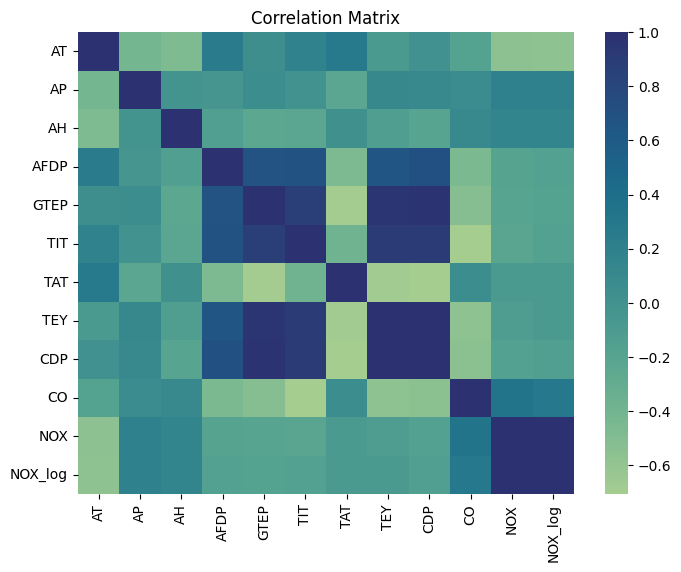

In [9]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=False, cmap="crest")
plt.title("Correlation Matrix")
plt.show()


In [9]:
x = df.drop(columns=['NOX','CO'])
y = df['NOX']

x.shape, y.shape

((36726, 10), (36726,))

In [10]:
X = df.drop(columns=['NOX', 'NOX_log', 'CO'])
y = df['NOX_log']

X.shape, y.shape


((36726, 9), (36726,))

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression


model = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("R2 mean:", r2_scores.mean())
print("R2 std:", r2_scores.std())
print("RMSE mean:", rmse_scores.mean())


R2 mean: 0.5353797191535117
R2 std: 0.011061014871083909
RMSE mean: 0.11497321918302346


In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

r2_rf = cross_val_score(rf, X, y, cv=cv, scoring='r2')
rmse_rf = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("RF R2 mean:", r2_rf.mean())
print("RF R2 std:", r2_rf.std())
print("RF RMSE mean:", rmse_rf.mean())


RF R2 mean: 0.8743100420905472
RF R2 std: 0.004680041241925235
RF RMSE mean: 0.05979665618682457


In [15]:
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

importances


AT      0.405863
TIT     0.145225
GTEP    0.098005
TAT     0.095778
AFDP    0.078769
TEY     0.051322
AH      0.049110
CDP     0.038430
AP      0.037497
dtype: float64

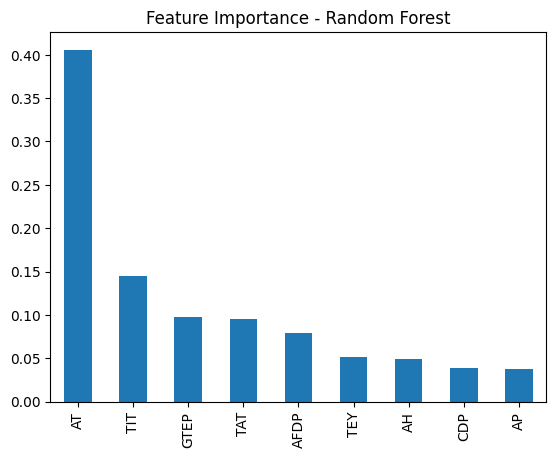

: 

In [ ]:
plt.figure()
importances.plot(kind='bar')
plt.title('Feature Importance - Random Forest')
plt.show()

In [ ]:
import shap
# Subset
X_sample = X.sample(500, random_state=42)

rf.fit(X, y)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)


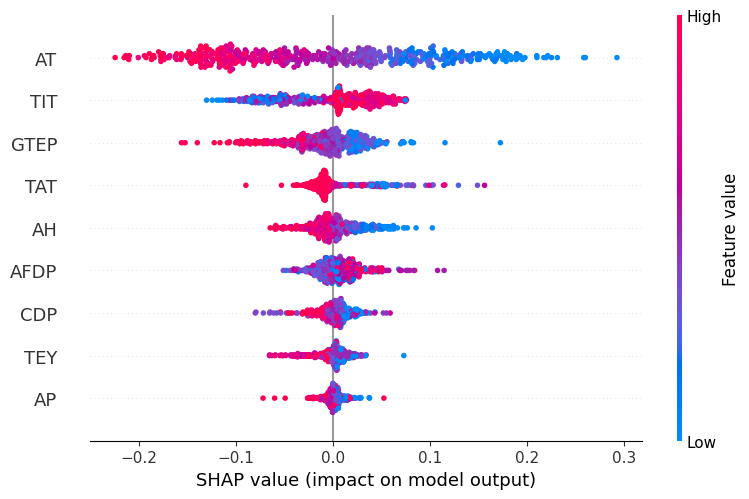

In [17]:
shap.summary_plot(shap_values, X_sample)


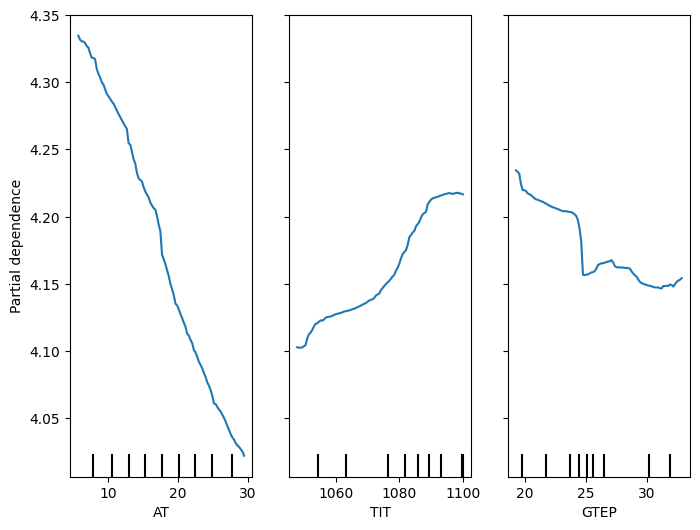

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ['AT', 'TIT', 'GTEP']

fig, ax = plt.subplots(figsize=(8,6))
PartialDependenceDisplay.from_estimator(
    rf, X, features_to_plot, ax=ax
)
plt.show()


In [ ]:


bounds = {col: (X[col].min(), X[col].max()) for col in X.columns}


n_samples = 5000


rand_data = pd.DataFrame({
    col: np.random.uniform(low=bounds[col][0],
                           high=bounds[col][1],
                           size=n_samples)
    for col in X.columns
})

pred_log = rf.predict(rand_data)

pred_nox = np.expm1(pred_log)

rand_data['pred_NOX'] = pred_nox


In [20]:
best_case = rand_data.sort_values('pred_NOX').iloc[0]
best_case


AT            34.434927
AP          1001.482380
AH            83.634569
AFDP           3.138190
GTEP          24.818971
TIT         1029.422661
TAT          535.870546
TEY          160.081007
CDP           11.698631
pred_NOX      42.075920
Name: 1338, dtype: float64

In [21]:
df['TEY'].describe()

count    36726.000000
mean       133.506079
std         15.619558
min        100.020000
25%        124.450000
50%        133.730000
75%        144.080000
max        179.500000
Name: TEY, dtype: float64

In [ ]:

tey_threshold = df['TEY'].quantile(0.75)

pareto_candidates = rand_data[
    (rand_data['pred_NOX'] <= rand_data['pred_NOX'].quantile(0.10)) &  # 10% کمترین NOx
    (rand_data['TEY'] >= tey_threshold)                                 # 25% بالاترین TEY
]

pareto_candidates.sort_values('pred_NOX').head()


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,pred_NOX
1338,34.434927,1001.482380,83.634569,3.138190,24.818971,1029.422661,535.870546,160.081007,11.698631,42.075920
3964,27.906872,998.655783,88.421479,2.436904,37.992197,1033.259909,543.220273,153.306056,13.406317,42.493363
1994,32.838216,999.763951,86.731038,3.679349,23.255944,1053.114634,523.218344,152.740630,14.757436,42.668802
2137,29.015716,1006.755338,89.724510,3.767419,34.052392,1015.509269,528.525806,170.589547,14.109152,42.748602
1343,31.477776,1004.941558,84.437654,2.302793,35.409981,1047.615010,523.407614,148.899373,12.355752,42.773802


In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

r2_xgb = cross_val_score(xgb, X, y, cv=cv, scoring='r2')
rmse_xgb = np.sqrt(-cross_val_score(xgb, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("XGBoost R2 mean:", r2_xgb.mean())
print("XGBoost R2 std:", r2_xgb.std())
print("XGBoost RMSE mean:", rmse_xgb.mean())


XGBoost R2 mean: 0.8328336360397008
XGBoost R2 std: 0.0032255610425630243
XGBoost RMSE mean: 0.06896849667743563
